In [2]:
import pandas as pd
import numpy as np
import os
import keras
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from keras.layers import Bidirectional, LSTM

2025-10-24 10:59:03.377178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 10:59:03.395201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 10:59:03.400983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 10:59:03.417485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 10:59:04.229618: W tensorflow/compiler/tf2

In [3]:
df = pd.read_csv("train_df_features.csv")

In [4]:
print(df.head())

              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000091_000000        Target  SEQ_000091                 0  SUBJ_032233   
1  SEQ_000091_000001        Target  SEQ_000091                 1  SUBJ_032233   
2  SEQ_000091_000002        Target  SEQ_000091                 2  SUBJ_032233   
3  SEQ_000091_000003        Target  SEQ_000091                 3  SUBJ_032233   
4  SEQ_000091_000004        Target  SEQ_000091                 4  SUBJ_032233   

       orientation                       behavior       phase  \
0  Seated Straight  Moves hand to target location  Transition   
1  Seated Straight  Moves hand to target location  Transition   
2  Seated Straight  Moves hand to target location  Transition   
3  Seated Straight  Moves hand to target location  Transition   
4  Seated Straight  Moves hand to target location  Transition   

                 gesture     acc_x  ...  tof_5_mean  tof_5_std  tof_5_min  \
0  Above ear - pull hair -4.492188  ...      

In [5]:
# Selecciona todas las columnas ToF
tof_cols = [c for c in df.columns if c.startswith("tof_")]

# Extrae los valores como array
tof_data = df[tof_cols].values
print("tof_data shape:", tof_data.shape)

tof_data shape: (457218, 340)


In [10]:
channels = 5
pixels_per_image = channels * 8 * 8  


usable_size = (tof_data.size // pixels_per_image) * pixels_per_image  
tof_data = tof_data.flatten()[:usable_size]  

X_images = tof_data.reshape(-1, channels, 8, 8).transpose(0, 2, 3, 1)

print("X_images shape:", X_images.shape)
columns_targets_gestures = [
    "Above ear - pull hair",
    'Cheek - pinch skin',
     'Eyebrow - pull hair',
    'Eyelash - pull hair',
    'Forehead - pull hairline',
    'Forehead - scratch',
    'Neck - pinch skin',
    'Neck - scratch',
]  
columns_non_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]


df['label_collapsed'] = df['gesture'].apply(
    lambda x: x if x in columns_targets_gestures else 'non_target'
)

n_samples = min(len(df), X_images.shape[0])
Ytrain = df['label_collapsed'].iloc[:n_samples].values
X_images = X_images[:n_samples]
print("X_images shape:", X_images.shape)
print("Ytrain shape:", Ytrain.shape)
print("Unique Classes:", set(Ytrain))

X_images shape: (485794, 8, 8, 5)
X_images shape: (457218, 8, 8, 5)
Ytrain shape: (457218,)
Unique Classes: {'Cheek - pinch skin', 'Eyebrow - pull hair', 'Above ear - pull hair', 'Eyelash - pull hair', 'non_target', 'Forehead - pull hairline', 'Neck - scratch', 'Forehead - scratch', 'Neck - pinch skin'}


In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(
    np.array(X_images), np.array(Ytrain),test_size=0.20, random_state=42)
    


print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

X_train = X_train / 255.0
X_test = X_test / 255.0

X train shape: (365774, 8, 8, 5)
Y train shape: (365774,)
X test shape: (91444, 8, 8, 5)
Y test shape: (91444,)


In [12]:
def tof_cnn_model(input_shape=(8,8,5), num_classes=2):
    inputs = keras.Input(shape=input_shape)

    #1st Conv Block
    x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)

    #2nd Conv Block
    x = keras.layers.Conv2D(64,(3,3), activation = "relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)

    #3th Con Block
    x = keras.layers.Conv2D(128,(3,3), activation = "relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.4)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)


    model = keras.Model(inputs,outputs)
    return model
    


In [13]:
def CNN_BiLSTM_model(input_shape=(64,5), num_classes=9):
    """
    CNN + BiLSTM hybrid model for sequential sensor data"
    """
    inputs = keras.Input(shape = input_shape)

    #First block
    Z1 = keras.layers.Conv1D(64, 3, activation="relu")(inputs)
    B1 = keras.layers.BatchNormalization()(Z1)
    P1 = keras.layers.MaxPooling1D(2)(B1)
    D1 = keras.layers.Dropout(0.30)(P1)

    #Second Block
    Z2 = keras.layers.Conv1D(128, 5, activation="relu")(D1)
    B2 = keras.layers.BatchNormalization()(Z2)
    Z3 = keras.layers.Conv1D(128, 5, activation="relu")(B2)
    P2 = keras.layers.MaxPooling1D(2)(Z3)
    D2 = keras.layers.Dropout(0.40)(P2)

    BILSTM = Bidirectional(LSTM(128, return_sequences=True))(D2)
    D3 = keras.layers.Dropout(0.40)(BILSTM)

    G1 = keras.layers.GlobalAveragePooling1D()(D3)

    x = keras.layers.Dense(512, activation="relu")(G1)
    B3 = keras.layers.BatchNormalization()(x)
    D4 = keras.layers.Dropout(0.50)(B3)
    x2 = keras.layers.Dense(256, activation="relu")(D4)
    D5 = keras.layers.Dropout(0.30)(x2)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(D5)
    model = keras.Model(inputs, outputs)

    return model
    

    

In [14]:
encoder = LabelEncoder()
Y_train_encoded = encoder.fit_transform(Y_train)
Y_test_encoded = encoder.transform(Y_test)

unique, counts = np.unique(Y_train_encoded, return_counts=True)
print(dict(zip(unique, counts)))

class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_encoded), y=Y_train_encoded)
class_weights = dict(enumerate(class_weights))
X_train_seq = X_train.reshape(-1, 64, 5)
X_test_seq = X_test.reshape(-1, 64, 5)

{0: 31272, 1: 30587, 2: 34001, 3: 31028, 4: 31246, 5: 31379, 6: 30387, 7: 33648, 8: 112226}


In [17]:
ConvModel = CNN_BiLSTM_model(input_shape=(64,5),num_classes=9)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

encoder = LabelEncoder()

Y_train_cat = to_categorical(Y_train_encoded, num_classes=9)
Y_test_cat = to_categorical(Y_test_encoded, num_classes=9)
ConvModel.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = ConvModel.fit(X_train_seq, 
                        Y_train_cat, 
                        epochs=10,
                        batch_size=32, 
                        validation_data=(X_test_seq, Y_test_cat),
                        class_weight=class_weights
                       )
ConvModel.summary()


Epoch 1/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 400s 35ms/step - accuracy: 0.1761 - loss: 0.3541 - val_accuracy: 0.2608 - val_loss: 0.3253
Epoch 2/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 393s 34ms/step - accuracy: 0.2466 - loss: 0.3286 - val_accuracy: 0.3119 - val_loss: 0.3167
Epoch 3/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 392s 34ms/step - accuracy: 0.2776 - loss: 0.3218 - val_accuracy: 0.3259 - val_loss: 0.3125
Epoch 4/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 393s 34ms/step - accuracy: 0.2982 - loss: 0.3166 - val_accuracy: 0.3393 - val_loss: 0.3100
Epoch 5/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 397s 35ms/step - accuracy: 0.3072 - loss: 0.3136 - val_accuracy: 0.3265 - val_loss: 0.3132
Epoch 6/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 394s 34ms/step - accuracy: 0.3140 - loss: 0.3113 - val_accuracy: 0.3488 - val_loss: 0.3061
Epoch 7/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 359s 31ms/step - accuracy: 0.3210 - loss: 0.3099 - val_accuracy: 0.3541 - val_loss: 0.3025
Epoch 8/10
11431/11431 ━━━━━━━━━━━━━━━━━━━━ 355s 31ms/s

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 62, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 27, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 23, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 11, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,963,293 (7.49 MB)

 Trainable params: 653,961 (2.49 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 1,307,924 (4.99 MB)

In [18]:


ConvModel.save("Tofs_CNN_MacroF1.h5")

/tmp/ipykernel_4011656/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_4011656/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

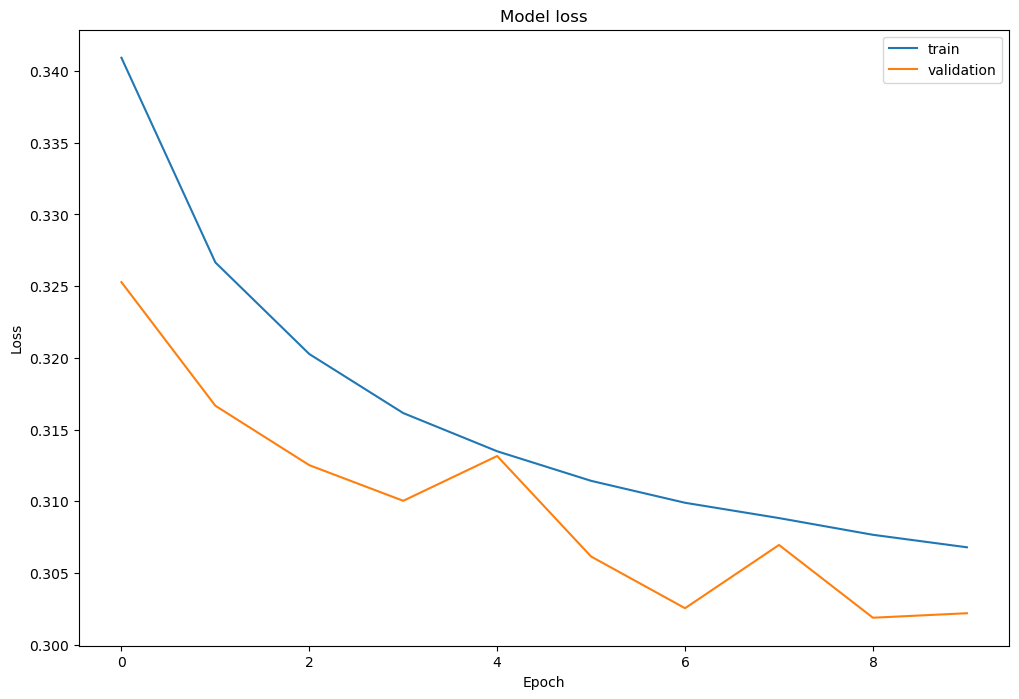

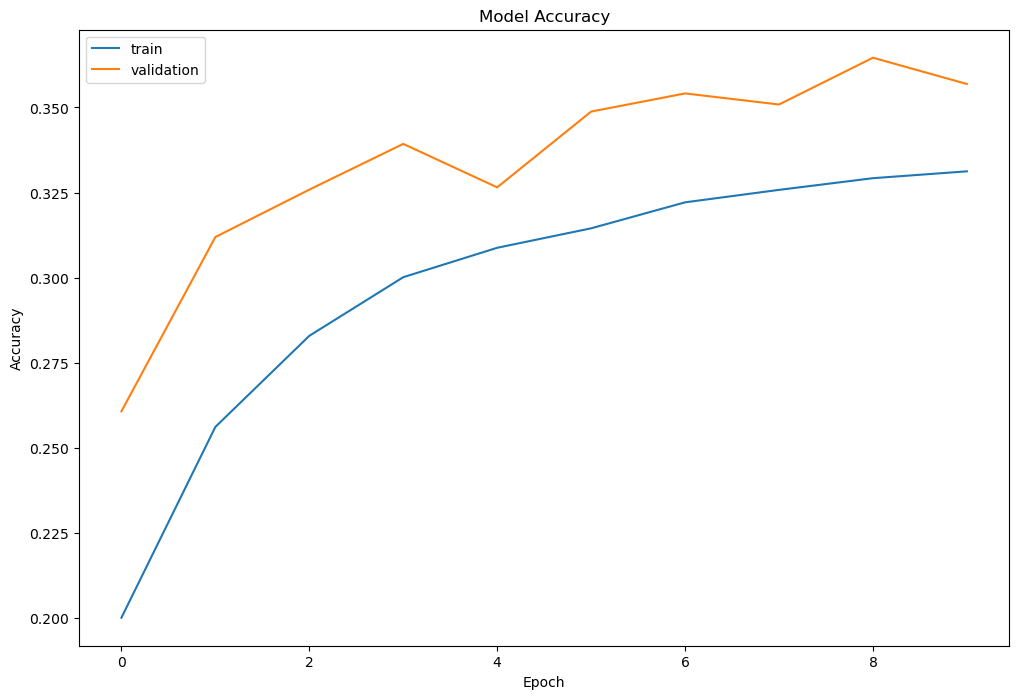

In [19]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')